[Source of data](#source_of_data)

[Prepare data with Python](#prepare_data)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time 
import random
import seaborn as sns
import sklearn 
import statsmodels.api as sm
import re
import os 
import time
import pickle
import pyspark
from pyspark import SparkContext
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import nltk

# Source of data
<a id='source_of_data'></a>

The data is downloaded from the Kaggle datasets. It is the years data of Dow Jones Index and news informations. 


<a id='prepare_data'></a>
# Prepare data with Python


We first treat our original data with python and store it to csv for latter load into sparkcontext

In [138]:
file = "./data2/DJIA_table.csv"

In [139]:
df = pd.read_csv(file).sort_values('Date')

In [140]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [141]:
print('The beginning date of the data is {}'.format(df.Date.iloc[0]))
print('The ending date of the data is {}'.format(df.Date.iloc[-1]))

The beginning date of the data is 2008-08-08
The ending date of the data is 2016-07-01


This is the sample data that we use from 20080808 - 20160701

# Use pyspark to do analysis

We first initialize a sparkcontext and create a initial rdd 

In [142]:
sc= pyspark.SparkContext('local')
rdd = sc.textFile('./data2/DJIA_table.csv')

In [143]:
header = sc.parallelize(rdd.take(1))
rdd1 = rdd.subtract(sc.parallelize(rdd.take(1)))
rdd1.take(3)

['2016-06-23,17844.109375,18011.070312,17844.109375,18011.070312,98070000,18011.070312',
 '2016-06-22,17832.669922,17920.160156,17770.359375,17780.830078,89440000,17780.830078',
 '2016-06-21,17827.330078,17877.839844,17799.800781,17829.730469,85130000,17829.730469']

First to see what is amount of data do we have

In [144]:
start = time.time()
print('The number of data sample we have is {}'.format(rdd.count()))
time.time() - start

The number of data sample we have is 1990


0.07454705238342285

Check out the features of the rdd

In [145]:
rdd.take(4)

['Date,Open,High,Low,Close,Volume,Adj Close',
 '2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141',
 '2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234',
 '2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688']

The first column is the date.

The following columns are open, high, low, close in a day. The last column is the same as the close column so we can just ignore it.

Now we clean the rdd and transform the data type so we can do the exploratory data analysis

In [146]:
rdd1 = rdd1.map(lambda x: x.split(','))
rdd1.take(3)

[['2016-06-23',
  '17844.109375',
  '18011.070312',
  '17844.109375',
  '18011.070312',
  '98070000',
  '18011.070312'],
 ['2016-06-22',
  '17832.669922',
  '17920.160156',
  '17770.359375',
  '17780.830078',
  '89440000',
  '17780.830078'],
 ['2016-06-21',
  '17827.330078',
  '17877.839844',
  '17799.800781',
  '17829.730469',
  '85130000',
  '17829.730469']]

# A first look at the overday return

In [147]:
open_price = rdd1.map(lambda x: float(x[1])) # start stock price
close_price = rdd1.map(lambda x: float(x[4])) # end stock price

In [148]:
open_price.take(4)

[17844.109375, 17832.669922, 17827.330078, 17736.869141]

In [149]:
close_price.take(4)

[18011.070312, 17780.830078, 17829.730469, 17804.869141]

In [150]:
daily_change_rate = rdd1.map(lambda x: float(x[4])/float(x[1])-1)
daily_change_rate.take(2)

[0.009356641650824837, -0.002907015283002967]

In [151]:
print("The mean of overday return is {}, variance is {}"
      .format(daily_change_rate.mean(), daily_change_rate.variance()))
print("The max of overday return is {}, min is {}".format(daily_change_rate.max(), daily_change_rate.min()))

The mean of overday return is 0.0003660357992929041, variance is 0.00015679008566899904
The max of overday return is 0.1093292980645828, min is -0.07783347590526868


## some visualization of overday return data

In [152]:
data = daily_change_rate.collect()

In [153]:
data[:10]

[0.009356641650824837,
 -0.002907015283002967,
 0.00013464669075502478,
 0.003833822049394975,
 -0.0035857276662145665,
 -0.004096170579892977,
 0.005309226622035146,
 0.0004078565872349671,
 0.0027831595181502244,
 -0.0058296275326272795]

/Users/lunzhang/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'density function')

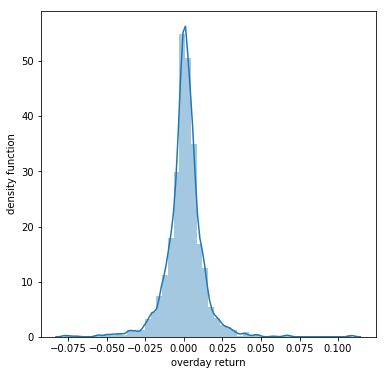

In [154]:
fig, axs = plt.subplots(figsize=(6,6), ncols=1, nrows=1)
sns.distplot(data, kde=1, norm_hist=True)
axs.set_xlabel('overday return')
axs.set_ylabel('density function')

In [155]:
dates = rdd1.map(lambda x: pd.to_datetime(x[0])).collect()

In [156]:
ts_open = pd.Series(open_price.collect(),index=dates)

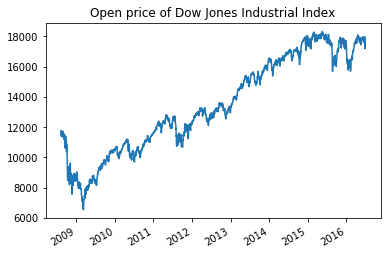

In [157]:
ts_open.plot(title="Open price of Dow Jones Industrial Index")

We can see the overday return data is centered around 0 (have a slight shift to right), and with a symmetric bell shape. And the general shape of the Dow Jones Index is first dropping and then increased for a long time and then vibrate on plateau

# Next step

First, We will try to basically analyze data to reveal some intrady trend in stock price movement. Then, we want to use some more sophisticated models like regression, time series model or RNN to predict future price by using historical time information. After that we will use News information to do text mining. Finally, we hope we can combine these models together to get a prediction model.

# NN and RNN

In this section we will use RNN model to do prediction of return of Dow Jones Index. The features 
that we will use is price information (open, high, low, close) and volume information.

We will train a sequential NN model first and then change to more complicated RNN and LSTM models

The module we will use for the deep learning is keras and the backend engine is tensorflow.

In [158]:
import keras

Using TensorFlow backend.


First we try to use the previous 10 days data to predict the next 5 days return

## Data preprocessing

In [159]:
df = pd.read_csv('./data2/DJIA_table.csv').sort_values('Date')

In [160]:
for i in range(1,11):
    if i == 1:
        X = np.array([df.Open.shift(1)])
    else:
        X = np.append(X, [np.array(df.Open.shift(i))],axis=0)
        
# first column is yesterday
X =X.T

In [161]:
X = X/X[:,9].reshape((len(X),1)) -1 

In [162]:
Y = np.array(df.Open.shift(-4))/np.array(df.Open) -1 
Y = Y. reshape((len(Y),1))

In [163]:
print(X.shape, Y.shape)

(1989, 10) (1989, 1)


In [164]:
XY = np.append(X,Y,axis= 1)
XY = XY[~np.isnan(XY).any(axis = 1)]
XY = np.delete(XY,9,1)
XY.shape

(1975, 10)

In [165]:
ratio = 0.9
train_cut = int(len(XY)*ratio)
XY_train  = XY[:train_cut]
XY_test = XY[train_cut:]
print(XY_train.shape, XY_test.shape)

(1777, 10) (198, 10)


Then we unify above into a more general function that can produce the training and testing data for any n and m days.

In [166]:
def nd_mr(n,m,df):
    assert((n>0)&(m>0))
    
    for i in range(1,n+1):
        if i == 1:
            X = np.array([df.Open.shift(1)])
        else:
            X = np.append(X, [np.array(df.Open.shift(i))],axis=0)

    # first column is yesterday
    X =X.T
    X = X/X[:,n-1].reshape((len(X),1)) -1 
    
    Y = np.array(df.Open.shift(-(m-1)))/np.array(df.Open) -1 
    Y = Y.reshape((len(Y),1))
                 
    XY = np.append(X,Y,axis= 1)
    XY = XY[~np.isnan(XY).any(axis = 1)]
    XY = np.delete(XY,n-1,1)
    #XY.shape
    return XY

def get_train_test(XY,train_ratio):
    ratio = train_ratio
    train_cut = int(len(XY)*ratio)
    XY_train  = XY[:train_cut]
    XY_test = XY[train_cut:]
    return XY_train, XY_test

In [167]:
XY = nd_mr(10,5,df)
XY_train, XY_test = get_train_test(XY,0.9)

In [168]:
print(XY_train.shape, XY_test.shape)

(1777, 10) (198, 10)


## Benchmark as the linear model

In order to set a bench mark we use linear model to do the predicition first

In [169]:
from sklearn import linear_model

x_train = XY_train[:,:-1]
y_train = XY_train[:,-1].reshape((len(XY_train),1))
x_test = XY_test[:,:-1]
y_test = XY_test[:,-1].reshape((len(XY_test),1))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

reg = linear_model.Ridge (alpha = 0)
reg.fit(x_train,y_train)

(1777, 9) (1777, 1)
(198, 9) (198, 1)


Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [170]:
print(reg.coef_)
print(reg.intercept_)

[[-0.11443767  0.09264025 -0.08272749  0.07982171  0.05082688 -0.00262436
   0.0178554  -0.0208569   0.03125321]]
[0.00112761]


In [171]:
print('Mean square error on training set is : {}'.\
      format(sklearn.metrics.mean_squared_error(y_train, reg.predict(x_train))))
print('Variance of y_train: {}'.format(np.var(y_train)))

Mean square error on training set is : 0.0005289457358759916
Variance of y_train: 0.0005333623262103877


The training seems to be slightly better than constant mean value prediction. Let's check the behavior on the testing set

In [172]:
print('Mean square error is : {}'.\
      format(sklearn.metrics.mean_squared_error(y_test, reg.predict(x_test))))
print('Variance of y_test: {}'.format(np.var(y_test)))

Mean square error is : 0.00029873840940170763
Variance of y_test: 0.00029672867190402803


The behavior is also the same, so we can conclude the linear model will just produce the constant 
estimation by taking the mean value which means the linear model is not useful in prediction open price changes.
So in the following we can just use the mean of y value as benchmark

## Building Sequential NN model (Naive y value)

We first start using sequential neural network model to do the predictions

In [173]:
from keras.models import Sequential
model = Sequential()

In [174]:
from keras.layers import Dense

In [175]:
model.add(Dense(units=64, activation='relu', input_dim = 9))
model.add(Dense(units=1,activation='linear'))

In [176]:
model.compile(loss='mean_squared_error',
              optimizer='sgd')

In [177]:
x_train = XY_train[:,:-1]
y_train = XY_train[:,-1].reshape((len(XY_train),1))
x_test = XY_test[:,:-1]
y_test = XY_test[:,-1].reshape((len(XY_test),1))

In [178]:
model.fit(x_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
1777/1777 [==============================] - 0s 237us/step - loss: 6.2275e-04
Epoch 2/5
1777/1777 [==============================] - 0s 139us/step - loss: 6.0005e-04
Epoch 3/5
1777/1777 [==============================] - 0s 145us/step - loss: 5.9291e-04
Epoch 4/5
1777/1777 [==============================] - 0s 144us/step - loss: 5.8993e-04
Epoch 5/5
1777/1777 [==============================] - 0s 152us/step - loss: 5.8748e-04


In [179]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)

198/198 [==============================] - 0s 162us/step


In [180]:
print(model.predict(x_train), np.mean(y_train))

[[ 0.00120823]
 [-0.00187322]
 [-0.00542443]
 ...
 [-0.00254151]
 [ 0.00585436]
 [-0.00090384]] 0.001103167008209025


In [186]:
print('The variance of the y_test is {}'.format(np.var(y_train)))
print('The mse of the prediction is {}'.format(np.var(y_test - model.predict(x_test))))

The variance of the y_test is 0.0005333623262103877
The mse of the prediction is 0.00032786520582554486


The variance of the NN model is better then the mean guess.

## Building Sequential NN model (categorical y value)

Instead of using the return value y directly we classify them into three categories: high increas,
high decease and not obvious change, and give them proportion of 25%, 25% 50%. We also use hot encoding
with respectively, high increas: (1, 0), high decrease (0, 1), not obvious change (0, 0)

In [187]:
lower_cut, upper_cut= np.quantile(XY[:,9],[0.25,0.75])
def helper(x):
    if x<= lower_cut:
        return (1,0)
    elif x>= upper_cut:
        return (0,1)
    else:
        return (0,0)
categories = np.array(list(map(lambda x: helper(x), XY[:,9])))

In [188]:
categories

array([[0, 0],
       [0, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]])

In [189]:
model_cat = Sequential()

model_cat.add(Dense(units=64, activation='relu', input_dim = 9))
model_cat.add(Dense(units=2, activation='softmax'))

model_cat.compile(loss='mean_squared_error',
              optimizer='Adam')


In [190]:
x_train = XY_train[:,:-1]
y_train = categories[:len(XY_train)]
x_test = XY_test[:,:-1]
y_test = categories[len(XY_train):]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1777, 9) (1777, 2)
(198, 9) (198, 2)


In [191]:
model_cat.fit(x_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
1777/1777 [==============================] - 1s 324us/step - loss: 0.2502
Epoch 2/5
1777/1777 [==============================] - 0s 187us/step - loss: 0.2500
Epoch 3/5
1777/1777 [==============================] - 0s 187us/step - loss: 0.2499
Epoch 4/5
1777/1777 [==============================] - 0s 200us/step - loss: 0.2499
Epoch 5/5
1777/1777 [==============================] - 0s 188us/step - loss: 0.2498


In [194]:
result = model_cat.predict(x_train)

In [195]:
result

array([[0.488504  , 0.511496  ],
       [0.48354578, 0.5164542 ],
       [0.48744154, 0.51255846],
       ...,
       [0.49933207, 0.5006679 ],
       [0.48826355, 0.51173645],
       [0.4916149 , 0.50838506]], dtype=float32)

The result are all arounded (0.5, 0.5) point which is the proportion of the cut we do, so the model 
is not well trained.

We changea hot coding method

In [196]:
def helper(x):
    if x<= lower_cut:
        return (1,0,0)
    elif x>= upper_cut:
        return (0,0,1)
    else:
        return (0,1,0)
categories = np.array(list(map(lambda x: helper(x), XY[:,9])))

In [197]:
categories

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [198]:
model_cat = Sequential()

model_cat.add(Dense(units=64, activation='relu', input_dim = 9))
model_cat.add(Dense(units=3, activation='softmax'))

model_cat.compile(loss='mean_squared_error',
              optimizer='sgd')

x_train = XY_train[:,:-1]
y_train = categories[:len(XY_train)]
x_test = XY_test[:,:-1]
y_test = categories[len(XY_train):]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

model_cat.fit(x_train, y_train, epochs=5, batch_size=10)
result = model_cat.predict(x_train)
result


(1777, 9) (1777, 3)
(198, 9) (198, 3)
Epoch 1/5
1777/1777 [==============================] - 0s 276us/step - loss: 0.2198
Epoch 2/5
1777/1777 [==============================] - 0s 170us/step - loss: 0.2153
Epoch 3/5
1777/1777 [==============================] - 0s 163us/step - loss: 0.2123
Epoch 4/5
1777/1777 [==============================] - 0s 158us/step - loss: 0.2103
Epoch 5/5
1777/1777 [==============================] - 0s 171us/step - loss: 0.2090


array([[0.27636775, 0.45175287, 0.27187946],
       [0.27538493, 0.44834962, 0.27626544],
       [0.2756407 , 0.4485015 , 0.27585778],
       ...,
       [0.28147665, 0.4499548 , 0.26856858],
       [0.27441764, 0.4514154 , 0.27416694],
       [0.27339014, 0.45161843, 0.27499142]], dtype=float32)

The final result is also close to the proportion (0.25,0.5,0.25) so the model is not well trained.
From above we can conclude the trivial deep learning model is not good at doing prediction for our problem

Then we go the following more complicated model which is designed to deal with time series data

## Building Recurrent NN model

We try the simple RNN model with fully connected layers to see whether it can give us some 
prediction power.

First try to prepare the data as before

In [199]:
XY = nd_mr(10,5,df)
XY_train, XY_test = get_train_test(XY,0.9)

In [200]:
print(XY_train.shape, XY_test.shape)

(1777, 10) (198, 10)


In [201]:
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model

In [202]:
x_train = XY_train[:,:-1]
y_train = XY_train[:,-1]
x_test = XY_test[:,:-1]
y_test = XY_test[:,-1]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1777, 9) (1777,)
(198, 9) (198,)


In [203]:
x_r  = x_train.reshape((len(x_train),len(x_train[0]),1))
y_r = y_train.reshape((len(y_train),1))

In [204]:
SEQLEN = 9
HIDDEN_SIZE = 32
BATCH_SIZE = 128
NUM_EPOCHS_PER_ITERATION = 25

model = Sequential()
model.add(SimpleRNN(units=32,input_shape = (9,1), return_sequences=False,
                    unroll=True))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="sgd")

In [205]:
model.fit(x_r, y_r, batch_size=128, epochs=25)

Epoch 1/25
1777/1777 [==============================] - 1s 321us/step - loss: 0.0012
Epoch 2/25
1777/1777 [==============================] - 0s 93us/step - loss: 0.0011
Epoch 3/25
1777/1777 [==============================] - 0s 95us/step - loss: 0.0011
Epoch 4/25
1777/1777 [==============================] - 0s 97us/step - loss: 0.0011
Epoch 5/25
1777/1777 [==============================] - 0s 97us/step - loss: 0.0010
Epoch 6/25
1777/1777 [==============================] - 0s 91us/step - loss: 0.0010
Epoch 7/25
1777/1777 [==============================] - 0s 96us/step - loss: 9.9567e-04
Epoch 8/25
1777/1777 [==============================] - 0s 92us/step - loss: 9.7070e-04
Epoch 9/25
1777/1777 [==============================] - 0s 90us/step - loss: 9.5035e-04
Epoch 10/25
1777/1777 [==============================] - 0s 92us/step - loss: 9.3046e-04
Epoch 11/25
1777/1777 [==============================] - 0s 93us/step - loss: 9.1110e-04
Epoch 12/25
1777/1777 [==============================

In [207]:
y_pred = model.predict(x_train.reshape((len(x_train),-1,1))).reshape((-1,))

In [208]:
y_pred.shape, y_train.shape

((1777,), (1777,))

In [209]:
mse(y_pred,y_train)

0.0007607275427524204

In [210]:
np.var(y_train)

0.0005333623262103877

The variance is even worse than the trivial mean prediction in the mean squared error sense

Now we can expect the pricing data is too noisy for the prediction model based on RNN. We can further move to the LSTM which is a special model of RNN but with some long term memory states. And the prediction is shifted to the positive part, as over dataset is slightly shifted to the positive direction.

In [211]:
np.sum(y_train[y_pred>0]>0)/len(y_train[y_pred>0]), np.sum(y_train[y_pred<0]<0)/len(y_train[y_pred<0])

(0.5879629629629629, 0.4375896700143472)

In [212]:
y_pred = model.predict(x_test.reshape((len(x_test),-1,1))).reshape((-1,))
mse(y_pred,y_test)

0.0004359860361162447

In [213]:
np.var(y_test)

0.00029672867190402803

In [214]:
np.sum(y_test[y_pred>0]>0)/len(y_test[y_pred>0])

0.5470085470085471

In [215]:
np.sum(y_test[y_pred<0]<0)/len(y_test[y_pred<0])

0.41975308641975306

The above indicates the naive RNN model is not useful in prediction the trend. Since there all models
are not making any reasonable predictions right now. We may doubt the price trend is too noisy to train.

Then we will move to the next stage to do the text mining and use it to do the prediction of Dow Jones Industrial Index

# Text Minning

In [4]:
d_news = pd.read_csv('./data2/Combined_News_DJIA.csv').sort_values('Date') # dow jones news
s_news = pd.read_csv('./data2/combined_stock_data.csv').sort_values('Date') # stock news
r_news = pd.read_csv('./data2/RedditNews.csv').sort_values('Date') # reddit news

In [5]:
print(d_news.Date.iloc[0], d_news.Date.iloc[-1]) 
print(s_news.Date.iloc[0], s_news.Date.iloc[-1]) 
print(r_news.Date.iloc[0], r_news.Date.iloc[-1]) 

2008-08-08 2016-07-01
2008-08-08 2016-07-01
2008-06-08 2016-07-01


## Clean reddit news data

It seems we have extra rows for the reddit news, so we just remove those extra news. And also we just choose the top10 news for each of the day

In [6]:
np.unique(r_news.groupby('Date').apply(lambda x: len(x)))

array([22, 23, 24, 25, 50])

In [7]:
temp =r_news.groupby('Date').apply(lambda x: np.array(x).reshape((len(x),))[:10])
temp = temp.loc[temp.index >= s_news.Date.iloc[0]].reset_index()
temp.columns = ['Date','data']

temp_r_data = pd.DataFrame()
temp_r_data['Date'] = temp.Date

for i in range(10):
    temp_r_data['top{}'.format(i+1)] = temp['data'].apply(lambda x: x[i])

r_clean_news = temp_r_data


In [8]:
with open('./data2/reddit_clean_news.csv','w') as file:
    r_clean_news.to_csv(file)

In [9]:
r_clean_news = pd.read_csv('./data2/reddit_clean_news.csv')

In [222]:
r_clean_news.head(2)

,Unnamed: 0,Date,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,2008-08-08,b'Georgian troops retreat from S. Osettain cap...,"b""The 'enemy combatent' trials are nothing but...","b""Breaking: Georgia invades South Ossetia, Rus...",b'150 Russian tanks have entered South Ossetia...,b'Did the U.S. Prep Georgia for War with Russia?',b'Russian tanks are moving towards the capital...,b'Russia Today: Columns of troops roll into So...,b'BREAKING: Musharraf to be impeached.',"b""Georgia 'downs two Russian warplanes' as cou...","b""Afghan children raped with 'impunity,' U.N. ..."
1,1,2008-08-09,b'Activist tries to show Tibetan flag at Olymp...,b'Georgia declares state of war with Russia. ',"b""Mark Almond: It's simplistic to cast Russia ...","b""Georgia's oil pipeline is key to U.S. support""",b'38 dead after being bitten by vampire bats',"b'Russian FM: NATO encouraged Georgia - ""it is...",b' Did Invisible Hands Turn Beijings Staging U...,b'Russia v. Georgia: The Oil &amp; Gas Implica...,b'American Killed By Chinese Man at The Olympics',"b'August 1, 2008: International Large-Scale Mi..."


We will first separately use the dow jones and stock news first as they are directly related to the financial 
market, and later we can try to add reddits data to see whether can improve the results and combine everything together.

In [223]:
d_news.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [10]:
X = np.array(s_news.loc[:,['Date']+['Top{}'.format(i+1) for i in range(25)]])

In [11]:
# prepare the overday return data
dow = pd.read_csv('./data2/DJIA_table.csv')
overday_return = np.array(dow.Close/dow.Open-1).reshape((len(dow),1))
date = np.array(dow.Date).reshape((len(dow),1))
overday_return = np.concatenate([date,overday_return],axis =1)[::-1]
with open('./data2/overday_return.csv','w') as file:
    pd.DataFrame(overday_return).to_csv(file)

In [226]:
overday_return =np.array(pd.read_csv('./data2/overday_return.csv'))[:,1:]
overday_return[:2]

array([['2008-08-08', 0.02643702701117423],
       ['2008-08-11', 0.0044911482889382634]], dtype=object)

In [227]:
X.shape, overday_return.shape

((1989, 26), (1989, 2))

## Learning by wordcount vector and logistic model

In the following we will use the logistic to do prediction based on the 
dow jones news and the overday up and down in of the index. We will use the word countvector to 
quantitize every day news.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
# import news of dow jones
d_news = pd.read_csv('./data2/Combined_News_DJIA.csv').sort_values('Date')
d_news.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
d_news = d_news.fillna(' ')
# y label the ups and dows of index
y = np.array(d_news.Label).reshape((-1,1))
# get the every news into np.array form
x = d_news.loc[:,'Top1':]
x = np.array(x.applymap(lambda x: x.lower()))
x = list(map(lambda x: ' '.join(x), x))

In [14]:
vectorize = CountVectorizer(ngram_range=(1,1))
x_vect = vectorize.fit_transform(x)
print(x_vect.shape)

(1989, 33244)


In [15]:
train_size = int(len(y)*0.9)
x_train = x_vect[:train_size,:]
y_train = y[:train_size]
x_test = x_vect[train_size:,:]
y_test = y[train_size:]

In [16]:
log_model = LogisticRegression()
log_model = log_model.fit(x_train, y_train)

/home/makashima/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/makashima/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [233]:
train_pred = log_model.predict(x_train)

In [234]:
pd.crosstab(y_train.reshape((-1,)), train_pred, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,832,0
1,0,958


The train error seems to be prefect, but this can lead to the problem of overfitting which we will 
see in the following

In [235]:
predictions = log_model.predict(x_test)

In [236]:
pd.crosstab(y_test.reshape((-1,)), predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,29,63
1,49,58


In [18]:
from sklearn.ensemble import RandomForestClassifier
rand_forrest=RandomForestClassifier()
rand_forrest=rand_forrest.fit(x_train,y_train)
train_pred = rand_forrest.predict(x_train)
pd.crosstab(y_train.reshape((-1,)), train_pred, rownames=["Actual"], colnames=["Predicted"])


/home/makashima/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/makashima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Predicted,0,1
Actual,,
0,828,4
1,15,943


In [19]:
predictions = rand_forrest.predict(x_test)
pd.crosstab(y_test.reshape((-1,)), predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,52,40
1,62,45


The cross table result shows the final result of prediction is almost useless. And the main reason is the training set is too small but the features of the 1-gram count vector is too big. The overfitting may occur in other models if we still transform the text information to the vectorcount.

In order to avoid the above problem we will try to use tf-idf to do the analysis. We will use the 
tf-idf to identify the similarity headlines and then we will choose the predictions on average of the most similar
label.

In [237]:
# prepare data
d_news = pd.read_csv('./data2/Combined_News_DJIA.csv').sort_values('Date')
d_news.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
y = np.array(d_news.Label)
data = d_news.fillna(' ')
data = data.iloc[:,2:].applymap(lambda x: x.lower())

In [238]:
# prepare train and test data
train_number = int(len(data)*0.9)
test_number = len(data) - train_number
full_data = np.array(data)
full_data = full_data.reshape((-1,))
train = np.array(data.iloc[:train_number,:])
test = np.array(data.iloc[train_number:,:])

In [239]:
# build tf-idf model on the full data
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = full_data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [240]:
# compute prediction on average of the most similar headline labels
x_train = X[:train_number,:]
label_pred = []
for i in range(train_number,len(data)):
    pred = x_train.dot(X[i*25:(i+1)*25].T).argmax(axis = 0 )
    label = int(y[np.array(pred)[0]].mean().round())
    label_pred.append(label)


In [241]:
# compare the predictions
y_test = y[train_number:]
y_pred = label_pred

pd.crosstab(np.array(y_test), np.array(y_pred), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,31,61
1,35,72


The result is just slightly better than the random guess and it is good at predicting the ups rather
then the downs. So maybe this can be a good classifier for one direction (ups) movememt of index.